# The Source Code for Lab Exercise 3.
## Steps
1. Preprocess the Data.
2. Create a Train and Test Split
3. Create a Convolutional Neural Network using Keras.
4. Experiment on Various Elements
5. Discussion and Analysis of Experiments.

# Possible Things to Experiment on
1. Other Preprocessing methods for Images.
2. Adding Max Pooling.
3. Changing number of Filters.
4. Changing Kernel Size.
5. Changing Learning Rate.
6. Changing Optimizers.

### Check Keras and Tensforflow Version and check for GPU compatibilities

In [1]:
import sys
import tensorflow as tf
import keras
import platform

print(f"Python Platform: {platform.version()}")
print(f"Python Version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print(f"GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
Python Version: 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:51:49) [Clang 16.0.6 ]
Tensorflow version: 2.16.1
Keras version: 3.2.1

GPU is available


### Checking for Invalid datasets

In [2]:
from pathlib import Path
import imghdr
import os

DATA_DIR = "hair_types"
IMAGE_EXTENSIONS = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(DATA_DIR).rglob("*"):
    if filepath.suffix.lower() in IMAGE_EXTENSIONS:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

## Preprocessing Images Section

### Import Tensorflow and Keras

In [3]:
import tensorflow as tf
import keras # we define like this for IntelliSense

# We define the constants for our images
BATCH_SIZE = 16
HEIGHT = 256
WIDTH = 256
IMAGE_SIZE = (HEIGHT, WIDTH)

### Loading Datasets for the Validation and Training splits

In [4]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    directory="hair_types",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337, # same as Demo
    validation_split=0.2, # use 20% as validation
    subset="training",
    label_mode="categorical"
)
val_dataset = keras.preprocessing.image_dataset_from_directory(
    directory="hair_types",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=1337, # same as Demo
    validation_split=0.2, # use 20% as validation
    subset="validation",
    label_mode="categorical"
)
# The target labels
class_names = train_dataset.class_names
print(class_names)

Found 981 files belonging to 3 classes.
Using 785 files for training.
Found 981 files belonging to 3 classes.
Using 196 files for validation.
['Curly_Hair', 'Straight_Hair', 'Wavy_Hair']


2024-04-21 01:25:12.398643: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-21 01:25:12.398674: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-04-21 01:25:12.398685: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-04-21 01:25:12.398715: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-21 01:25:12.398738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Visualizing the initial dataset

2024-04-21 01:25:13.118681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


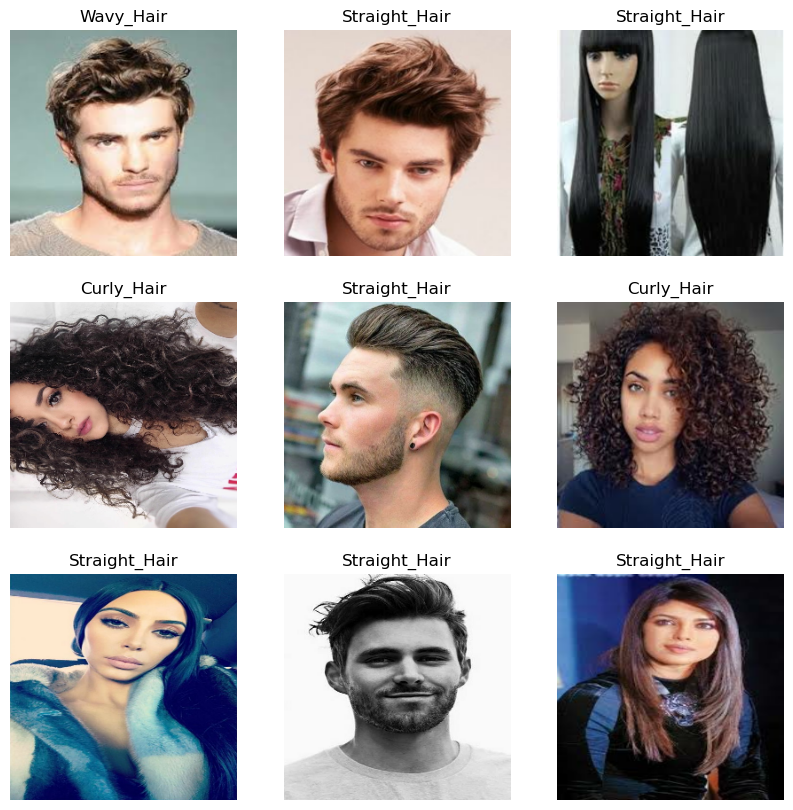

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

### Ways to Preprocess Images - Data Augmentation using keras.Layers

In [6]:
from keras import layers # We import like this for IntelliSense
data_augmentation_methods = keras.Sequential([
   layers.RandomFlip('horizontal_and_vertical'),
   layers.RandomRotation(factor=0.8),
   layers.RandomBrightness(factor=0.2),
   #layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  
   # Shift within 20% of image size
   #layers.RandomZoom(height_factor=0.2, width_factor=0.2),
   layers.RandomContrast(factor=0.4),
])

### Visualizing how these methods affect images

2024-04-21 01:25:14.163478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


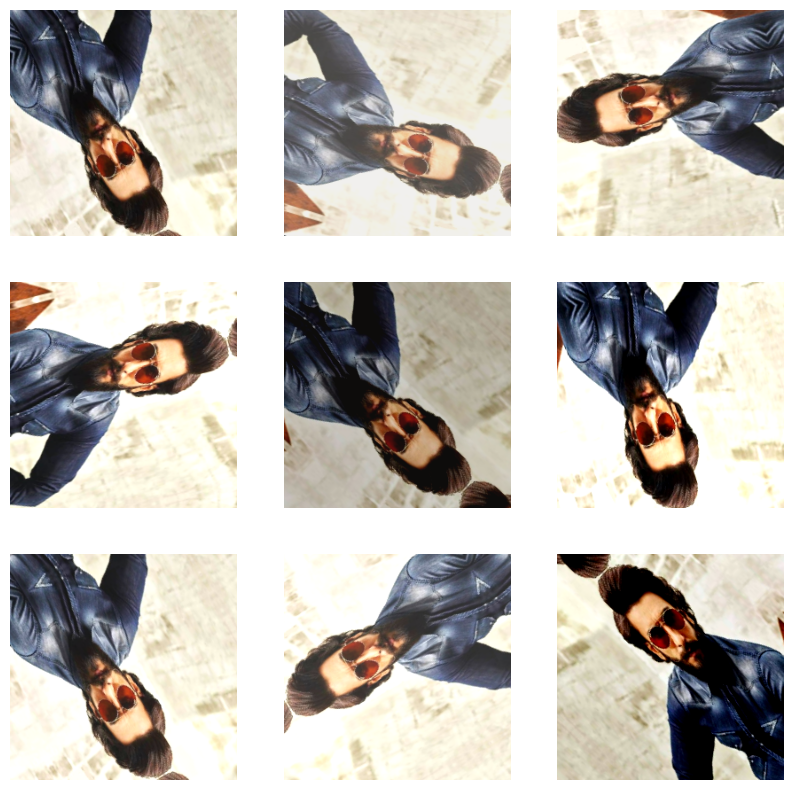

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation_methods(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")
plt.show()

### GPU Optimization

In [8]:
from tensorflow import data as tf_data
# Configuring dataset for performance
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_dataset = train_dataset.prefetch(tf_data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf_data.AUTOTUNE)

## Creating a Convolutional Neural Network using Keras

In [9]:
# 2. Adding Max Pooling.
# 3. Changing number of Filters.
# 4. Changing Kernel Size.
from keras import regularizers
model = keras.models.Sequential()

# Preprocessing Layer
model.add(keras.Input(shape=IMAGE_SIZE + (3,)))
model.add(layers.Rescaling(1.0 / 255))

# Convolutional Layer
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# Output Layer
model.add(layers.Flatten())

model.add(layers.Dense(units=256, activation="relu", 
                       kernel_regularizer=regularizers.l1_l2())) # 0.01 default

model.add(layers.Dense(units=3, activation="softmax"))


# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,585,475 (112.86 MB)

 Trainable params: 29,585,475 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

### Util Methods

In [10]:
# Dynamic Learning Rate
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 12
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) 
                                              / epochs_drop))
    return lr

In [11]:
# 5. Changing Learning Rate.
# 6. Changing Optimizers.
EPOCHS = 30
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, 
                                      monitor="val_loss"),
    # keras.callbacks.EarlyStopping(patience=5),
]

cnn = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,  
    callbacks=callbacks,
)

Epoch 1/30


2024-04-21 01:25:14.895533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.3515 - loss: 2.5802 - val_accuracy: 0.4847 - val_loss: 1.0803 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.5138 - loss: 1.0197 - val_accuracy: 0.4439 - val_loss: 1.0117 - learning_rate: 0.0010
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.5816 - loss: 0.8515 - val_accuracy: 0.5306 - val_loss: 0.9641 - learning_rate: 0.0010
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.7542 - loss: 0.6066 - val_accuracy: 0.5459 - val_loss: 1.0267 - learning_rate: 0.0010
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 0.8431 - loss: 0.4235 - val_accuracy: 0.6122 - val_loss: 1.2252 - learning_rate: 0.0010
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.9431 - loss: 0.2478 - val_accuracy: 0.6020 - val_loss: 1.5470 - learning_rate: 0.0010
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9468 - loss: 0.1866 - val_accura

## Evaluation of the Model

### Predicting a specific Image

In [12]:
img_path = (
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--" +
    "layered-natural-hair-natural-black-hairstyles.jpg"
)
img = tf.keras.preprocessing.image.load_img(img_path, 
                                            target_size=(HEIGHT, WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Predict probabilities
predictions = model.predict(img_array)[0]  

# Scale predictions to percentages
total_percentage = sum(predictions)
scaled_predictions = [p * 100 / total_percentage for p in predictions]

class_names = ["Curly Hair", "Straight Hair", "Wavy Hair"]  
percentage_str = ", ".join(["%.2f percent %s" % (p, class_names[i]) for i, 
                            p in enumerate(scaled_predictions)])
print("This image is " + percentage_str + ".")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
This image is 100.00 percent Curly Hair, 0.00 percent Straight Hair, 0.00 percent Wavy Hair.


### Predicting a Random Image

hair_types/Wavy_Hair/
17256d7b3bf03716aeeadaf4f8967f27.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
This image is 0.00 percent Curly Hair, 0.02 percent Straight Hair, 99.98 percent Wavy Hair.


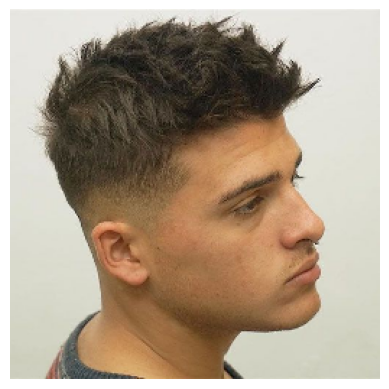

In [13]:
import os
import random
folder_number = random.randint(1, 3)  # Generate a random number between 1-3
if folder_number == 1:
    dataset_dir = "hair_types/Curly_Hair/"
elif folder_number == 2:
    dataset_dir = "hair_types/Straight_Hair/"
else:
    dataset_dir = "hair_types/Wavy_Hair/"

print(dataset_dir)
file_list = os.listdir(dataset_dir)

random_file = random.choice(file_list)
print(random_file)
image_path = os.path.join(dataset_dir, random_file)

img = tf.keras.preprocessing.image.load_img(image_path, 
                                            target_size=(HEIGHT, WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

# Make predictions
predictions = model.predict(img_array)[0]


# Scale predictions to percentages
total_percentage = sum(predictions)
scaled_predictions = [p * 100 / total_percentage for p in predictions]

class_names = ["Curly Hair", "Straight Hair", "Wavy Hair"]  
percentage_str = ", ".join(["%.2f percent %s" % (p, class_names[i]) for i, 
                            p in enumerate(scaled_predictions)])
print("This image is " + percentage_str + ".")
plt.imshow(img)
plt.axis('off')
plt.show()

### Visualization in Respect to Epochs

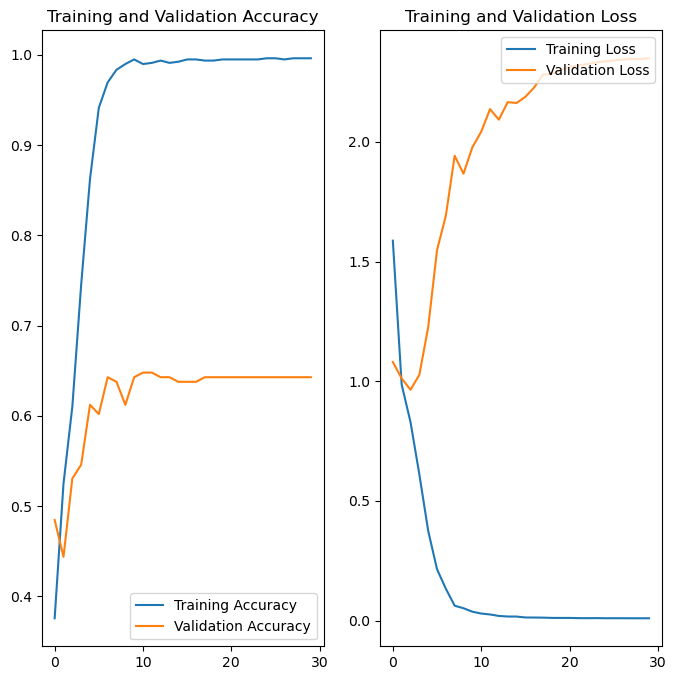

In [14]:
acc = cnn.history['accuracy']
val_acc = cnn.history['val_accuracy']

loss = cnn.history['loss']
val_loss = cnn.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()